In [46]:
import json
import pandas as pd
import numpy as np
import scipy as sc
from collections import Counter
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from os.path import join
from config import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Loading

In [19]:
data_file_name = '../data/plot_data.tsv'
feature_file_name = '../features/orocessed'

In [69]:
chunks = pd.read_csv(
    data_file_name,
    error_bad_lines=False,
    chunksize=10000, 
    encoding='utf-8',
    sep='\t'
)

num_fields_list = []
num_rows_list = []

num_traces = 0
traces_with_transforms = 0
chart_data_field_counts = Counter()
layout_field_counts = Counter()

num_grids_counts = Counter()
user_counts = Counter()

fields_and_src = []
fields = []
src_sets = []

for chunk_num, chunk in enumerate(chunks):
    for i, chart in chunk.iterrows():
        user, chart_id = chart.fid.split(':')
        
        user_counts[user] += 1
        
        table_data = json.loads(chart.table_data)
        fields = table_data[list(table_data.keys())[0]]['cols']
        num_fields = len(fields)
        num_fields_list.append(num_fields)
        
        num_rows = np.max([ len(d['data']) for d in fields.values() ])
        num_rows_list.append(num_rows)
        
        srcs = set()    
        chart_data = json.loads(chart.chart_data)
        for trace in chart_data:
            src_keys = [ k for k in trace.keys() if 'src' in k ]
            for src_key in src_keys:
                srcs.add(trace[src_key])
        fields_and_src.append([ num_fields, len(srcs) ])

## Plots Per User

In [72]:
user_count_values = pd.Series(list(user_counts.values()))
percentile_cutoff = np.percentile(user_count_values, 99.9)
user_count_values_trimmed = user_count_values[user_count_values <= percentile_cutoff]

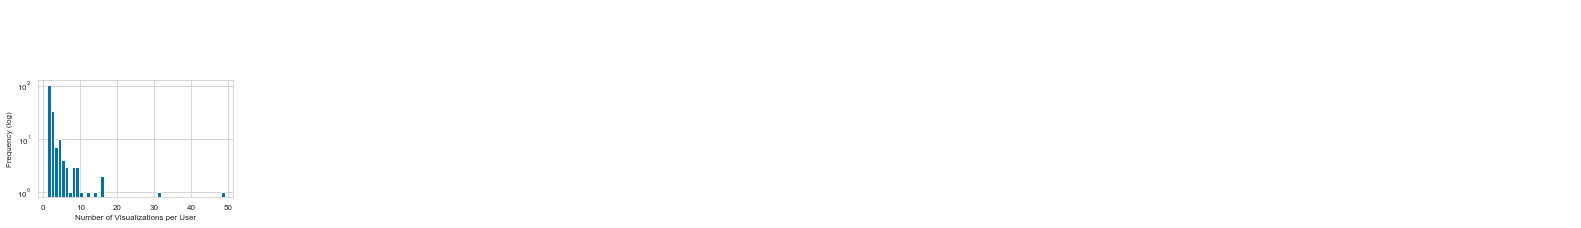

In [76]:
# Binned log-linear histogram
sns.set_style("whitegrid")
fig, ax = plt.subplots()

user_count_values_trimmed.hist(
    color=colors_dict['blue'],
    alpha=1,
    bins=50,
    figsize=(width, height)
)

ax.set_yscale('log')

median = np.median(user_count_values_trimmed)
mean = np.mean(user_count_values_trimmed)

plt.annotate(
    'Median = {0:.2f}\nMean = {1:.2f}'.format(median, mean),
    xy=(400, 1800),
    bbox=dict(boxstyle="square,pad=0.5", fc="w", ec='#cccccc')
)

plt.ylabel('Frequency (log)')
plt.xlabel('Number of Visualizations per User')
plt.savefig('../results/plots_per_user_log_log.svg', format='svg', bbox_inches='tight')
plt.savefig('../results/plots_per_user_log_log.pdf', format='pdf', bbox_inches='tight')

## Number of Fields

In [74]:
num_fields_counts = Counter(num_fields_list)
num_fields_counts_df = pd.DataFrame.from_dict(
    num_fields_counts, orient='index'
)
num_fields_counts_df = num_fields_counts_df.rename(columns={
    'index': 'num_fields',
    0: 'count'
}).reset_index()

num_fields_counts_df_subset = num_fields_counts_df[num_fields_counts_df['index'] <= 25]

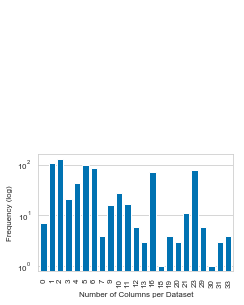

In [77]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()

num_fields_counts_df_subset.plot.bar(
    y='count',
    ax=ax,
    color=colors_dict['blue'],
    width=0.75,
    figsize=(width, height),
    legend=False
)
ax.xaxis.grid(which='major')
ax.set_yscale('log')
# ax.set_ylim([0, np.max(num_fields_counts_df_subset['count'])])
plt.ylabel('Frequency (log)')
plt.xlabel('Number of Columns per Dataset')

median = np.median([ x for x in num_fields_list if x<= 25])
mean = np.mean([ x for x in num_fields_list if x <= 25])

plt.annotate(
    'Median = {0:.2f}\nMean = {1:.2f}'.format(median, mean),
    xy=(15, 74000),
    bbox=dict(boxstyle="square,pad=0.5", fc="w", ec='#cccccc')
)

fig.set_size_inches(width, height)
plt.savefig('../results/plots_per_field_log_linear.svg', format='svg', bbox_inches='tight')
plt.savefig('../results/plots_per_field_log_linear.pdf', format='pdf', bbox_inches='tight')

## Rows per Dataset

In [86]:
max_x_val = np.max(num_rows_list)

counts, bin_edges = np.histogram(
    np.array(num_rows_list),
    bins='auto'
)

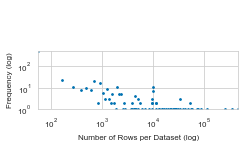

In [87]:
fig, ax = plt.subplots(figsize=(width, height))

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

x = bin_centers
y = counts

plt.scatter(
    x,
    y,
    c=colors_dict['blue'],
    s=3
)

eps = 1

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([np.min(bin_centers), np.max(bin_centers)])
ax.set_ylim([np.min(counts) + 1, np.max(counts)])

plt.annotate(
    'Median = {0:.2f}\nMean = {1:.2f}'.format(median, mean),
    xy=(40000, 16200),
    bbox=dict(boxstyle="square,pad=0.5", fc="w", ec='#cccccc')
)

plt.ylabel('Frequency (log)')
plt.xlabel('Number of Rows per Dataset (log)')
plt.savefig('../results/rows_per_dataset_log_log.svg', format='svg', bbox_inches='tight')
plt.savefig('../results/rows_per_dataset_log_log.pdf', format='pdf', bbox_inches='tight')